In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mglearn

%matplotlib inline

In [175]:
charge_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_eu.csv", encoding='utf-8-sig')
charge_na = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_na.csv", encoding='utf-8-sig')

# 환불 유저와 전체 유저 집합을 구함
def createAbuserDataSet(data_set):
    data_set = data_set[data_set.charge_status >= 60].drop_duplicates(['user_no'], keep='last')
        
    data_set = pd.DataFrame(data_set, columns=['user_no'])
    data_set['Class'] = 1
    return data_set
def createAllDataSet(data_set):
    data_set = pd.DataFrame(data_set, columns=['user_no']).drop_duplicates(['user_no'], keep='last')
    return data_set

charge_eu_abuser = createAbuserDataSet(charge_eu)
charge_na_abuser = createAbuserDataSet(charge_na)

# 전체 유저에서 환불 유저를 뺀 것이 일반 유저
charge_eu_normal = createAllDataSet(charge_eu).drop(charge_eu_abuser.index)
charge_eu_normal['Class'] = 0
charge_na_normal = createAllDataSet(charge_na).drop(charge_na_abuser.index)
charge_na_normal['Class'] = 0
print("eu 일반 유저의 수: ", len(charge_eu_normal))
print("na 일반 유저의 수: ", len(charge_na_normal))
print("eu 환불 유저의 수: ", len(charge_eu_abuser))
print("na 환불 유저의 수: ", len(charge_na_abuser))

# 데이터 통합 및 인덱스 재정렬
charge_all = pd.concat([charge_eu_abuser, charge_eu_normal, charge_na_abuser, charge_na_normal])
charge_all = charge_all.reset_index(drop=True)

eu 일반 유저의 수:  228078
na 일반 유저의 수:  130860
eu 환불 유저의 수:  726
na 환불 유저의 수:  921


In [169]:
charge_eu.columns.values

array(['Unnamed: 0', 'user_no', 'standard_country_code', 'charge_status',
       'charge_no', 'payment_method_no', 'charge_amount', 'bonus_amount',
       'charge_datetime', 'charge_product_name', 'hash_ip', 'ip_addr'], dtype=object)

In [174]:
def createFeatureForAmount(transactions, charges):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[],[],[],[]]

    for user_id in charges.user_no:
        sample = transactions[transactions.user_no == user_id]
        list[0].append(np.sum(sample.iloc[:, 6]))
        list[1].append(np.mean(sample.iloc[:, 6]))
        list[2].append(np.std(sample.iloc[:, 6]))
        list[3].append(np.sum(sample.iloc[:, 7]))
        list[4].append(np.mean(sample.iloc[:, 7]))
        list[5].append(np.std(sample.iloc[:, 7]))               
        
    charges['charge_amount_sum'] = list[0]
    charges['charge_amount_avg'] = list[1]
    charges['charge_amount_stddev'] = list[2]
    charges['bonus_amount_sum'] = list[3]
    charges['bonus_amount_avg'] = list[4]
    charges['bonus_amount_stddev'] = list[5]

def getTime(date):
    date = date.replace("-", " ")
    dates = date.split(" ")
    year = dates[0]
    month = dates[1]
    day = dates[2]
    hour = dates[3]
    return str(year), str(month), str(day), str(hour)

def betweenTimeandTime(date, date2):
    remainTime = 0
    year, month, day, hour = getTime(date)
    year2, month2, day2, hour2 = getTime(date2)
    remainTime += (int(year2) - int(year)) * (24 * 30 * 12)
    remainTime += (int(month2) - int(month)) * (24 * 30)
    remainTime += (int(day2) - int(day)) * 24
    remainTime += int(hour2) - int(hour)
    return remainTime

def createBeforeAfterTransaction(transactions, charges):
    list = [[],[],[],[],[]]
    
    for user_id in charges.user_no:
        samples = transactions[transactions.user_no == user_id]
        samples = samples.sort_values(by=['charge_datetime'], ascending=True)

        # 전, 후 ip
        count = 0
        isFirst = True
        firstIp = ""
        #print(samples)
        for ip in samples['hash_ip']:
            if isFirst :
                firstIp = ip
                isFirst = False
            if firstIp != ip:
                count += 1
                firstIp = ip
        list[0].append(count)
        
        count = 0
        isFirst = True
        firstCountry = ""
        #print(samples)
        for country in samples['standard_country_code']:
            if isFirst :
                firstCountry = country
                isFirst = False
            if firstCountry != country:
                count += 1
                firstCountry = country
        list[1].append(count)
        
        count = 0
        isFirst = True
        firstPayment = ""
        #print(samples)
        for payment in samples['payment_method_no']:
            if isFirst :
                firstPayment = payment
                isFirst = False
            if firstPayment != payment:
                count += 1
                firstPayment = payment
        list[2].append(count)
        
        count = 0
        isFirst = True
        firstProduct = ""
        #print(samples)
        for product in samples['charge_product_name']:
            if isFirst :
                firstProduct = product
                isFirst = False
            elif firstProduct != product:
                count += 1
                firstProduct = product
        list[3].append(count)

        sum = 0.0
        count = 0
        isFirst = True
        firstDate = ""

        for date in samples['charge_datetime']:
            if isFirst :
                firstDate = date
                isFirst = False
            if firstDate != date:
                sum = betweenTimeandTime(firstDate, date)
                count += 1
                firstDate = date
        if count != 0 :
            list[4].append(sum / count)
        else: list[4].append(0)
        
    charges['beforeAfterIp'] = list[0]
    charges['beforeAfterCountry'] = list[1]
    charges['beforeAfterPayment'] = list[2]
    charges['beforeAfterProduct'] = list[3]
    charges['beforeAfterTime'] = list[4]

def createCountTrasactionBeforeCharge(transactions, charges):
    list = [[],[],[]]
    for user_id in charges.user_no:
        samples = transactions[transactions.user_no == user_id]
        samples = samples.sort_values(by=['charge_datetime'], ascending=True)
        count = 0
        for sample in samples['charge_status']:
            if sample == 30: count += 1
            elif sample != 30: break
        list[0].append(count)
        
        sum = 0.0
        count = 0
        isFirst = True
        firstAmount = ""
        
        for amount in samples['charge_amount']:
            if isFirst :
                firstAmount = amount
                isFirst = False
            if firstAmount != amount:
                sum += firstAmount - amount
                count += 1
                firstAmount = amount
        if count != 0 :
            list[1].append(sum / count)
        else: list[1].append(0)
            
        sum = 0.0
        count = 0
        isFirst = True
        firstAmount = ""
        
        for amount in samples['bonus_amount']:
            if isFirst :
                firstAmount = amount
                isFirst = False
            if firstAmount != amount:
                sum += firstAmount - amount
                count += 1
                firstAmount = amount
        if count != 0 :
            list[2].append(sum / count)
        else: list[2].append(0)
    charges['transactionCountBeforeCharge'] = list[0]
    charges['beforeAfterAmount'] = list[1]
    charges['beforeAfterBonus'] = list[2]

In [176]:
# under sampling 과정
number_abuser = len(charge_all[charge_all.Class == 1])
abuser_indices = charge_all[charge_all.Class == 1].index
normal_indices = charge_all[charge_all.Class == 0].index

random_normal_indices = np.random.choice(normal_indices, number_abuser, replace = False)
random_normal_indices = np.array(random_normal_indices)

charge_all_sample_indices = np.concatenate([abuser_indices, random_normal_indices])
charge_all_sample = charge_all.iloc[charge_all_sample_indices, :]

# 모든 transaction 생성
transaction_charge = pd.concat([charge_eu, charge_na])

In [177]:
createFeatureForAmount(transaction_charge, charge_all_sample)
createCountTrasactionBeforeCharge(transaction_charge, charge_all_sample)
createBeforeAfterTransaction(transaction_charge, charge_all_sample)

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [178]:
# 모든 type을 float로 변경함
charge_all_sample.iloc[:, 2:] = charge_all_sample.iloc[:, 2:].astype(np.float)
# 필요없는 key들 drop 과정
charge_all_sample = charge_all_sample.drop(charge_all_sample.columns[0], axis=1)
#charge_all_sample.head()

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [179]:
# sample data modeling
from sklearn.tree import *
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *

X = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = RandomForestClassifier(n_estimators=100, random_state=2)
model2 = svm.SVC()
model3 = DecisionTreeClassifier(max_depth = 4)
model4 = GaussianNB()

model.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
print("훈련(randomforest) 세트 정확도: {:.3f}".format(model.score(X_train, y_train)))
print("테스트(randomforest) 세트 정확도: {:.3f}".format(model.score(X_test, y_test)))
print("훈련(SVM) 세트 정확도: {:.3f}".format(model2.score(X_train, y_train)))
print("테스트(SVM) 세트 정확도: {:.3f}".format(model2.score(X_test, y_test)))
print("훈련(DecisionTree) 세트 정확도: {:.3f}".format(model3.score(X_train, y_train)))
print("테스트(DecisionTree) 세트 정확도: {:.3f}".format(model3.score(X_test, y_test)))
print("훈련(naive-bayes) 세트 정확도: {:.3f}".format(model4.score(X_train, y_train)))
print("테스트(naive-bayes) 세트 정확도: {:.3f}".format(model4.score(X_test, y_test)))

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련(randomforest) 세트 정확도: 1.000
테스트(randomforest) 세트 정확도: 0.958
훈련(SVM) 세트 정확도: 1.000
테스트(SVM) 세트 정확도: 0.682
훈련(DecisionTree) 세트 정확도: 0.934
테스트(DecisionTree) 세트 정확도: 0.932
훈련(naive-bayes) 세트 정확도: 0.763
테스트(naive-bayes) 세트 정확도: 0.751


In [180]:
charge_all_sample.head()

,Class,charge_amount_sum,charge_amount_avg,charge_amount_stddev,bonus_amount_sum,bonus_amount_avg,bonus_amount_stddev,transactionCountBeforeCharge,beforeAfterAmount,beforeAfterBonus,beforeAfterIp,beforeAfterCountry,beforeAfterPayment,beforeAfterProduct,beforeAfterTime
0,1,33167.0,315.876190,236.270938,6591.0,62.771429,117.742031,7.0,-14.764706,-1.470588,26.0,5.0,13.0,14.0,1.895833
1,1,1300.0,433.333333,612.825877,30.0,10.000000,14.142136,3.0,650.000000,15.000000,1.0,0.0,1.0,2.0,0.500000
2,1,500.0,500.000000,0.000000,0.0,0.000000,0.000000,1.0,1000.000000,0.000000,0.0,0.0,0.0,0.0,2.000000
3,1,10000.0,10000.000000,0.000000,0.0,0.000000,0.000000,1.0,20000.000000,0.000000,0.0,0.0,0.0,0.0,2015.000000
4,1,16900.0,5633.333333,5235.986589,1360.0,453.333333,599.184631,3.0,3900.000000,340.000000,0.0,0.0,0.0,4.0,1944.000000


In [181]:
# charge_amount_sum, avg, stddev, bouns_amount_sum, avg, stddev
# transactionCountBeforeCharge, beforeAfterAmount, beforeAfterIp, beforeAfterCountry
# beforeAfterPayment, beforeAfterProduct, beforeAfterTime
model.feature_importances_

array([ 0.21,  0.17,  0.03,  0.07,  0.07,  0.02,  0.03,  0.13,  0.07,
        0.03,  0.02,  0.03,  0.03,  0.09])

In [182]:
from sklearn.metrics import *

print("SVM 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model2.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("Decision Tree 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model3.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("naive bayes 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model4.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("Random Forest 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

SVM 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy- score: 0.6820388349514563
precision- score: 0.6246418338108882
recall- score: 1.0
f1- score: 0.7689594356261023
AUC-Curve:0.6623711340206185

             precision    recall  f1-score   support

          0       1.00      0.32      0.49       388
          1       0.62      1.00      0.77       436

avg / total       0.80      0.68      0.64       824

Decision Tree 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy- score: 0.9320388349514563
precision- score: 0.9502369668246445
recall- score: 0.9197247706422018
f1- score: 0.9347319347319347
AUC-Curve:0.9328005296509978

             precision    recall  f1-score   support

          0       0.91      0.95      0.93       388
          1       0.95      0.92      0.93       436

avg / total       0.93      0.93      0.93       824

naive bayes 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy- score: 0.7512135922330098
precision- score: 0.9425287356321839
recall- sc

In [183]:
import itertools

from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.965596330275


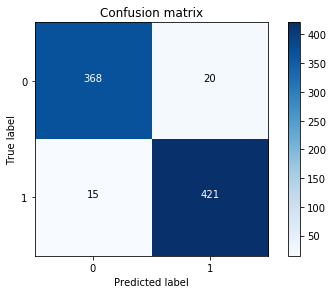

In [184]:
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

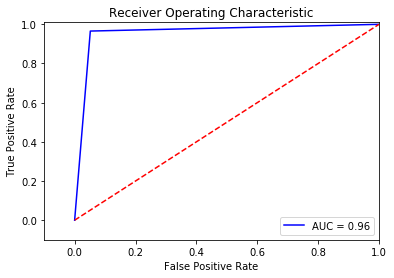

In [185]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()